In [1]:
import numpy as np
import scipy as sp
import pandas as pd
import scipy
import scipy.stats
from scipy.stats import norm
import math
import random
import matplotlib.pyplot as plt
import pickle
from EM import EM
from plot import plot

### Data Generation

In [3]:
class Model:
    # num_tseries is the number of time series generated by Model, each is time_length long
    # missing is the probability of an observation missing, default to zero 
    def __init__(self, time_length, num_tseries, missing=0):
        self.T = time_length
        self.num_tseries = num_tseries
        # model parameters
        self.A = np.array([[-.9, -.8], [-.5, -.3]]) # the coefficients a_j's stored in a matrix
        self.b = np.array([.6, .4])
        self.num_treatments = self.A.shape[1]
        self.num_chronic = self.b.shape[0]
        # noise are the variance, not standard deviation
        # noise for transition should be larger than noise for observation
        self.noise_0 = .01
        self.noise_1 = 1
        self.noise_2 = .1
        self.init_z = 6
        self.missing = missing
        # simulated data
        self.z = np.zeros((self.num_tseries, self.T))
        self.y = np.zeros((self.num_tseries, self.T))
        self.X = np.zeros((self.num_tseries, self.T, self.num_treatments))
        self.c = np.zeros((self.num_tseries, self.num_chronic))
        self.pi = np.zeros((self.num_tseries, self.T))
        
    def set_X(self, n):
        for t in range(self.T):
            self.X[n, t, :] = np.random.binomial(n=1, p=0.3, size=self.A.shape[1])# np.random.randint(2, size = self.num_treatments)

    def set_c(self, n):
        self.c[n, :] = np.random.randint(2, size = self.num_chronic)
        
    def transition(self, prev):
        z = np.random.normal(prev, np.sqrt(self.noise_1), 1)
        return z

    def emission(self, z, n, t):
        treatment_effect = 0
        for j in range(np.shape(self.A)[0]):
            if t-1 >= j:
                treatment_effect += np.dot(self.A[j, :], self.X[n, t-1-j, :])
        pi = treatment_effect + np.dot(self.b, self.c[n, :]) # total added effect
        prob = np.random.uniform(0, 1, 1)
        if prob < self.missing and t > 0:
            y = np.nan
        else:
            mean = z + pi
            y = np.random.normal(mean, np.sqrt(self.noise_2), 1)
        return y, pi
    
    def pct_missing(self, n):
        pct = np.shape(np.where(np.isnan(self.y[n, :]))[0])[0]/self.T*100
        print('missing {}% of observations'.format(pct))
    
    # generate a single trajectory indexed n
    def gen_trajectory(self, n):
        self.set_X(n)
        self.set_c(n)
        self.z[n, 0] = np.random.normal(self.init_z, np.sqrt(self.noise_0), 1)
        self.y[n, 0], self.pi[n, 0] = self.emission(self.z[n, 0], n, 0)
        for t in range(1, self.T):
            self.z[n, t] = self.transition(self.z[n, t-1])
            self.y[n, t], self.pi[n, t] = self.emission(self.z[n, t], n, t)
    
    # plot the trajectory indexed n
    def plot_trajectory(self, n):
        times = list(range(self.T))
        fig = plt.figure()
        plt.plot(times, self.y[n, :], label = 'observed')
        plt.plot(times, self.z[n, :], label = 'counterfactual')
        for t in np.nonzero(self.X[n, :, :])[0]:
            plt.axvline(x=t, color='g', linestyle='--')
        plt.xlabel('time (hr)')
        plt.ylabel('INR')
        plt.title('Simulated trajectory')
        plt.legend()
        fig.set_figheight(8)
        fig.set_figwidth(15)
        plt.show()
    
    # generate and plot multiple trajectories 
    def run_simulation(self):
        for n in range(self.num_tseries):
            self.gen_trajectory(n)
            #self.plot_trajectory(n)
            self.pct_missing(n)

In [4]:
%%capture
model = Model(50, 10, 0.4)
model.run_simulation()

In [5]:
em = EM(model.y, model.X, model.c, model.A.shape[0], 0, train_pct = .8, single_effect=False)
em.run_EM(500)

max iterations: 500 reached


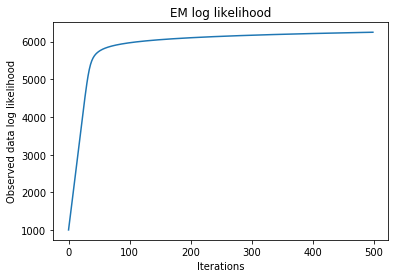

In [6]:
plt.plot([i for i in range(len(em.log_lik))], em.log_lik)
plt.xlabel('Iterations')
plt.ylabel('Observed data log likelihood')
plt.title('EM log likelihood')
plt.show()

In [7]:
em.get_MSE()

nan

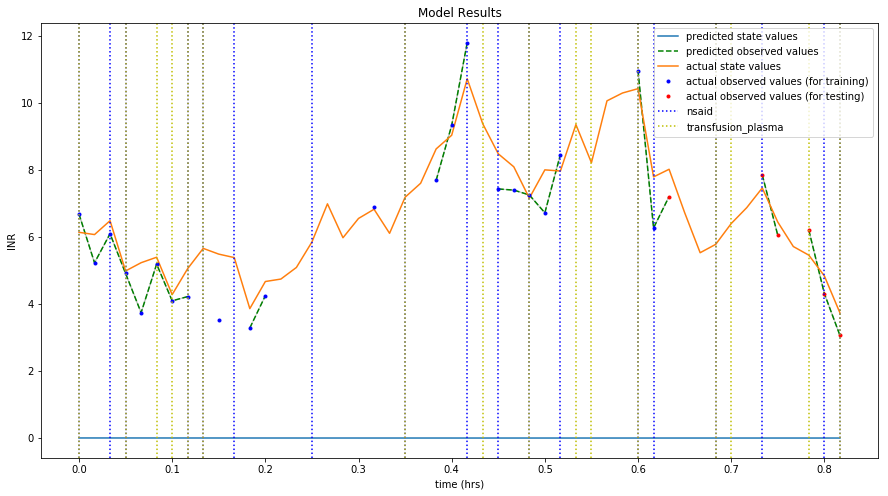

Patient 1


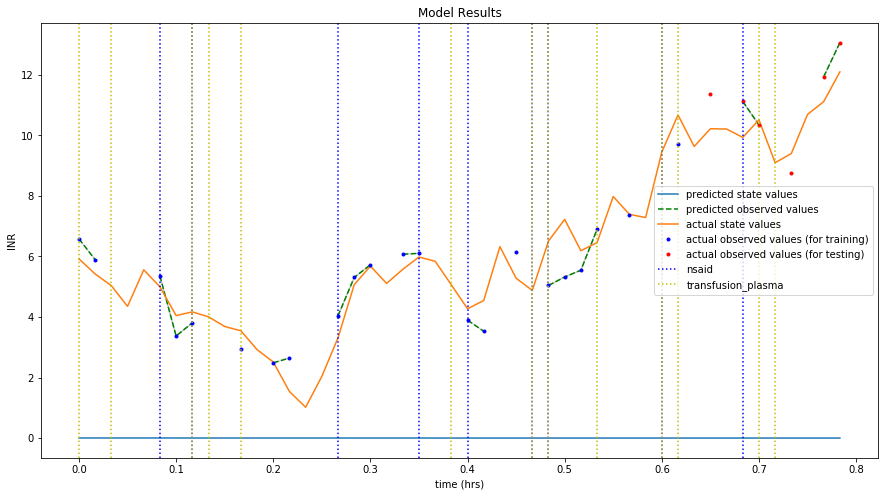

Patient 2


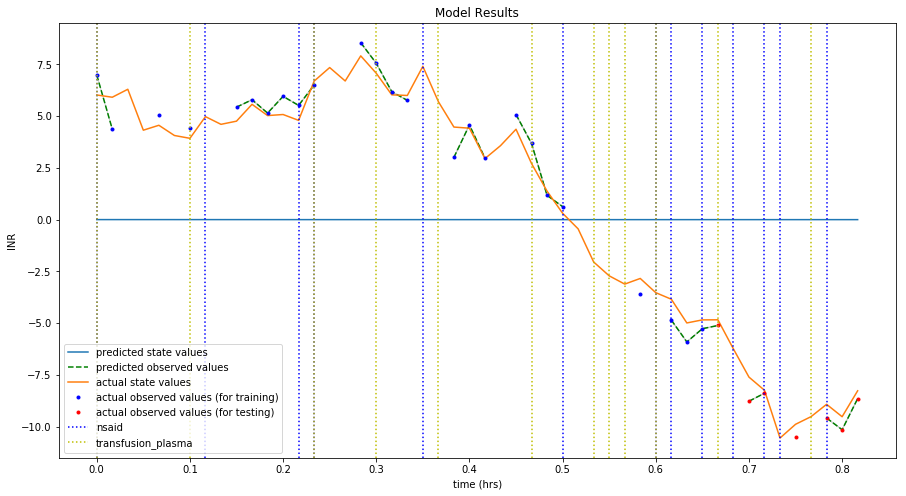

Patient 3


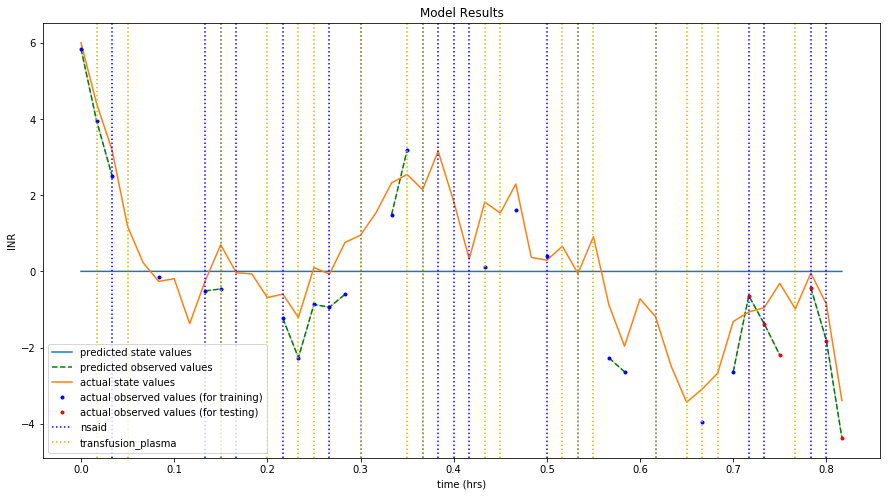

Patient 4


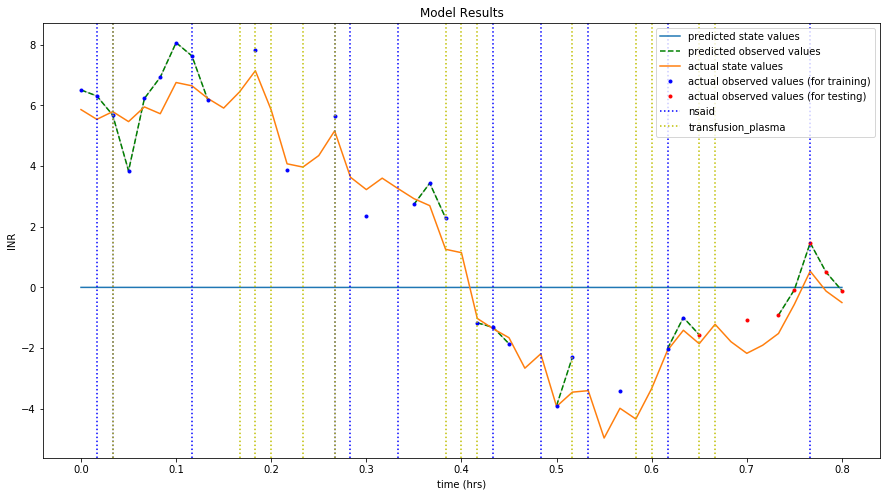

Patient 5


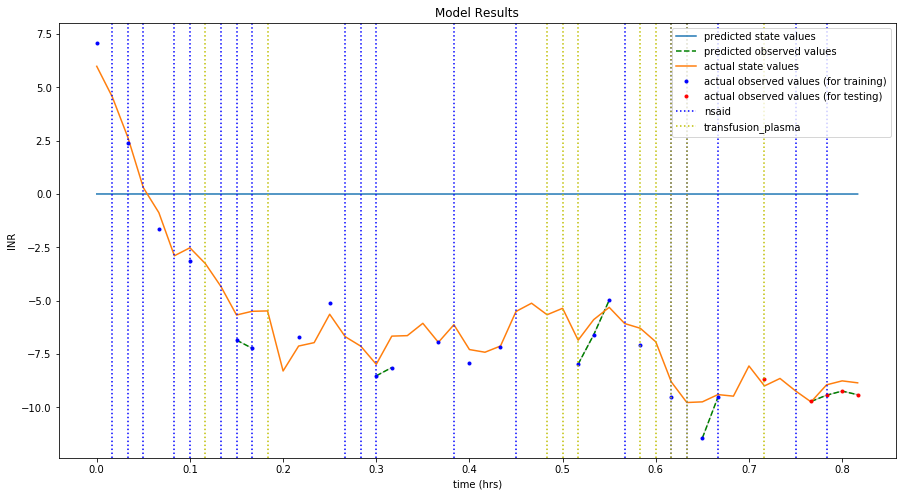

Patient 6


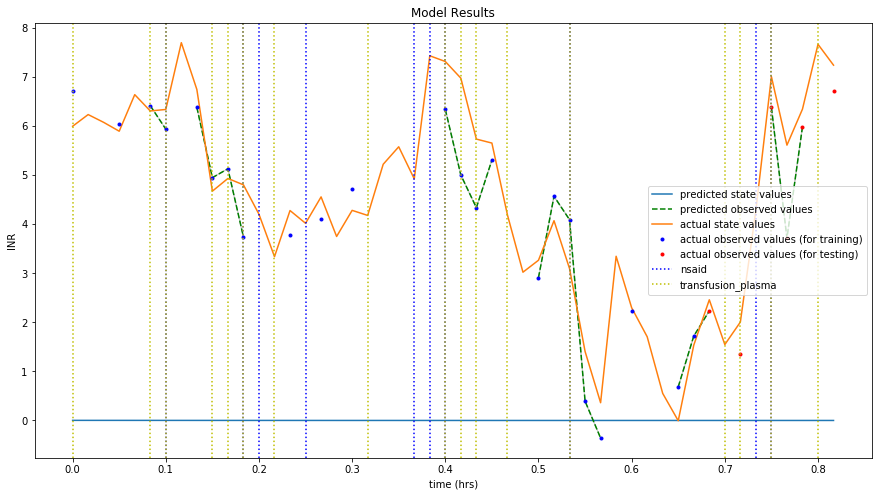

Patient 7


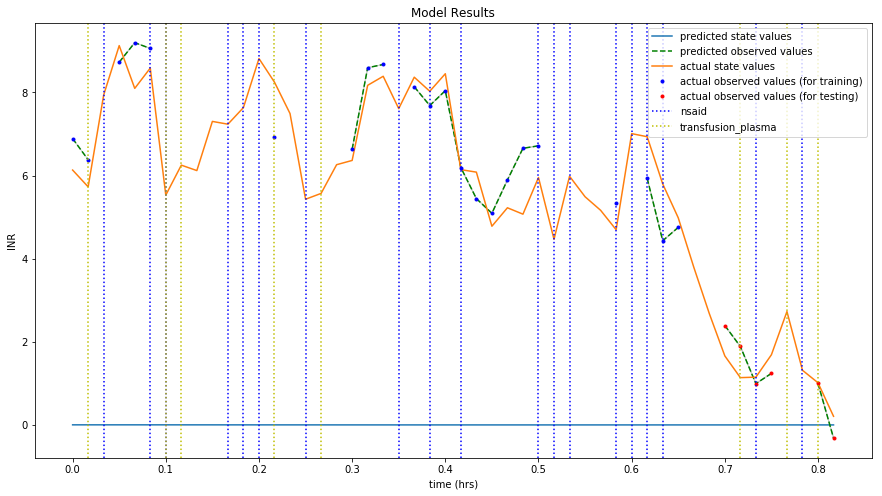

Patient 8


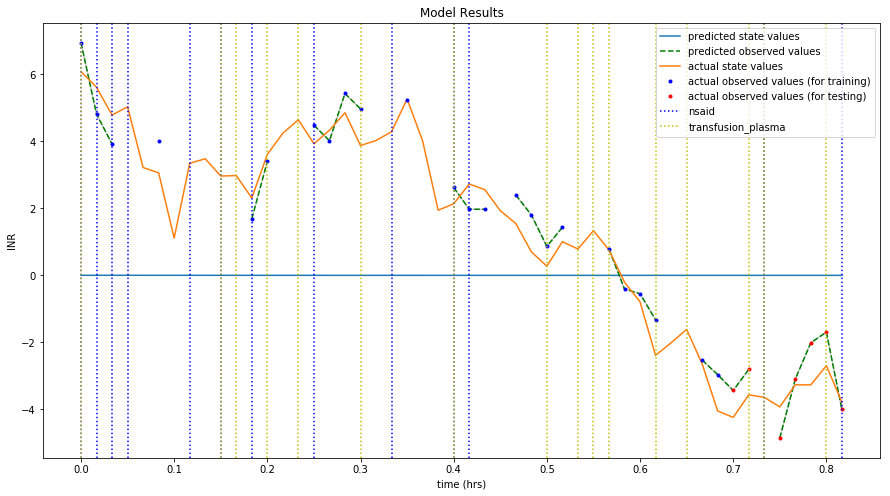

Patient 9


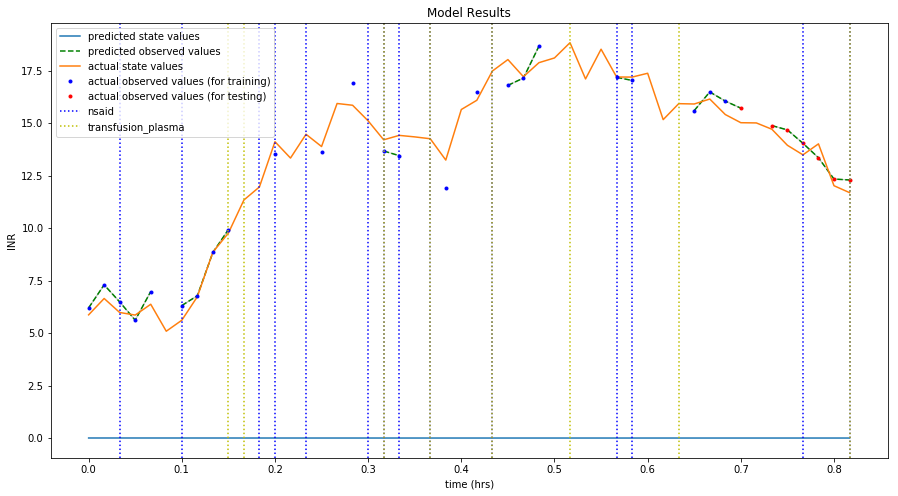

In [8]:
for n in range(model.y.shape[0]):
    plot(em, n, bin_size=1, true_model=True, model=model)

In [9]:
print('estimated params: {}'.format(em.params))
print('true params: {}'.format([model.A, model.b]))
print('estimated initial state mean: {}'.format(em.init_z))
print('true initial state mean: {}'.format(model.init_z))
print('estimated sigma_0: {}'.format(em.sigma_0))
print('true sigma_0: {}'.format(model.noise_0))
print('estimated sigma_1: {}'.format(em.sigma_1))
print('true sigma_1: {}'.format(model.noise_1))
print('estimated sigma_2: {}'.format(em.sigma_2))
print('true sigma_2: {}'.format(model.noise_2))
print('estimated ratio: {}'.format(em.sigma_1/em.sigma_2))
print('true ratio: {}'.format(model.noise_1/model.noise_2))

estimated params: [-0.25680856 -0.22370378 -0.28190122 -1.54823786  6.6786572  -1.64251215]
true params: [array([[-0.9, -0.8],
       [-0.5, -0.3]]), array([0.6, 0.4])]
estimated initial state mean: 0.001970837529537533
true initial state mean: 6
estimated sigma_0: 2.24509702275317e-11
true sigma_0: 0.01
estimated sigma_1: 8.376254377664003e-09
true sigma_1: 1
estimated sigma_2: 2.1789571558745144e-11
true sigma_2: 0.1
estimated ratio: 384.41574470986933
true ratio: 10.0


### Last Observation Carry Forward

In [10]:
# assume the first observation is not nan and the data array is not entirely nan
def LBCF(data):
    filled = np.zeros(data.shape)
    for n in range(data.shape[0]):
        for i, y in enumerate(data[n, :]):
            if np.isnan(y):
                filled[n, i] = filled[n, i-1]
            else:
                filled[n, i] = y
    return filled

### Notes on the current model

1. Identifying coefficients is still somewhat challenging (often off by a little), especially when the noises are larger.
2. When the coefficients are too small i.e. closer to the noise value, the model is unable to recover them.
3. The model has trouble identifying the noise values.  